In [1]:
## Assessing the quality of the genes in our remaining cells
generate_matrix = F
matrix_destination = "matrix.cellQC.geneQC.rds"
source("load_matrix.R")

Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsp

## Normalisation

Now that we have removed uninformative cells and genes, we must now normalise our count matrix so that we can compare gene expression levels across cells without having to concern ourselves about the general variability between different cells.

Here we will try 4 different methods of normalisation:

 * **RAW** - log(counts)
 * **CPM** - Counts per million, sum the counts of each cell and use it to divide each element multiplied by a million
 * **TMM** - Trimmed Mean of M-values, the average after removing upper + lower extreme values
 * **SF** - Scale Factor or Relative-Log-Expression (RLE), scale all expression to the geometric mean of some pseudo-reference cell (calculated as the mean across all cells). EdgeR and DeSeq.

In [2]:
library(data.table)
library(scran)
library(scater)


Attaching package: ‘data.table’

The following object is masked from ‘package:SummarizedExperiment’:

    shift

The following object is masked from ‘package:GenomicRanges’:

    shift

The following object is masked from ‘package:IRanges’:

    shift

The following objects are masked from ‘package:S4Vectors’:

    first, second

Loading required package: BiocParallel


In [3]:
sce_raw <- copy(sce)
sce_cpm <- copy(sce)
sce_sf <- copy(sce)
sce_tmm <- copy(sce)
#sce_scran <- copy(sce)

sce_raw$namer = "RAW"
sce_cpm$namer = "CPM"
sce_tmm$namer = "TMM"
#sce_scran$namer = "scran"
sce_sf$namer = "SF"

logcounts(sce_raw) <- log2(counts(sce_raw) + 1)
logcounts(sce_cpm) <- log2(calculateCPM(sce_cpm, use.size.factors = FALSE) + 1)
sce_sf  <- normaliseExprs(sce_sf, method = "RLE", return_log = TRUE, return_norm_as_exprs = TRUE)
sce_tmm <- normaliseExprs(sce_tmm, method = "TMM", return_log = TRUE, return_norm_as_exprs = TRUE)

# scran CPM norm
#not enough cells in at least one cluster for any 'sizes'
#qclust <- quickCluster(sce_scran, min.size = 3)
#sce_scran <- computeSumFactors(sce_scran, sizes = 10, clusters = qclust)
#sce_scran <- normalize(sce_scran)


A comparison of the various normalisation methods


,ACCATG,GAGTGA,CACTCA,CATGTC,ACAGGA,GTACCA,ACAGAC,ACCAAC,GTGAAG
RAW,2.000000,1.584963,1.584963,2.584963,3.000000,2.807355,1.584963,3.321928,1.000000
CPM,1.774760,1.937796,2.445531,2.530504,2.513820,2.767571,2.640865,2.467764,1.055505
SF,1.766287,1.899238,2.570625,2.527900,2.480991,2.769593,2.841742,2.455022,1.034502
TMM,1.759452,1.897186,2.205480,2.581224,2.560528,2.779281,2.424423,2.504441,1.078652


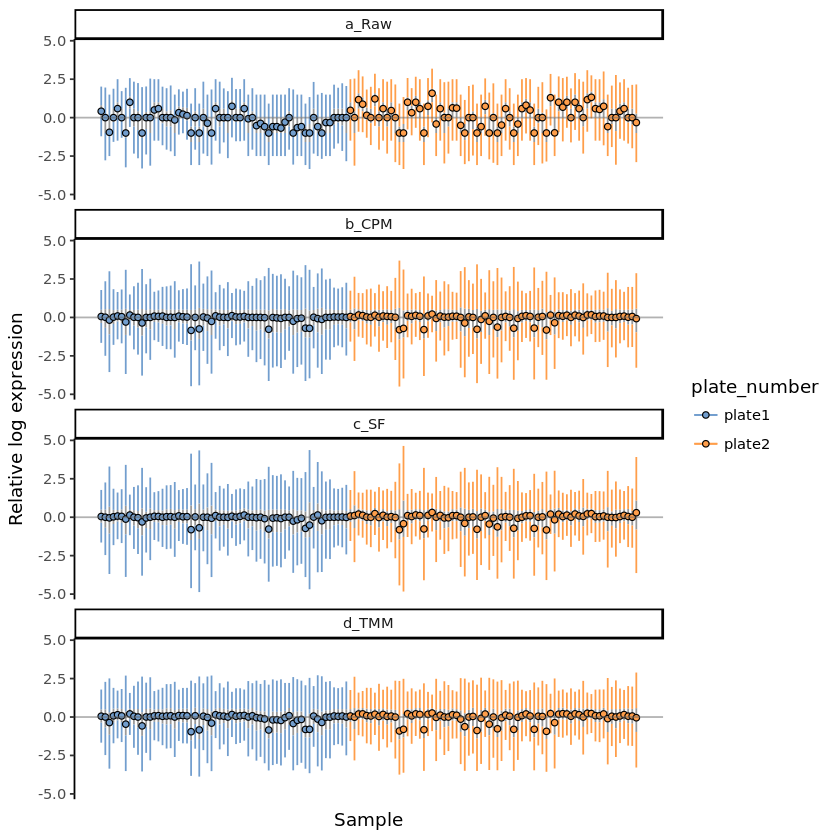

In [4]:
message("A comparison of the various normalisation methods")

tableau <- rbind(
    head(logcounts(sce_raw), 1),
    head(logcounts(sce_cpm), 1),
    head(logcounts(sce_sf), 1),
    head(logcounts(sce_tmm), 1)
    #head(logcounts(sce_scran), 1)
)
#rownames(tableau) <- c("RAW", "CPM", "SF", "TMM", "SCRAN")
rownames(tableau) <- c("RAW", "CPM", "SF", "TMM")
tableau[,1:9]

plotRLE(
    sce,  # not used
    exprs_mats = list(
        a_Raw   = logcounts(sce_raw),
        b_CPM   = logcounts(sce_cpm),
        c_SF    = logcounts(sce_sf),
        d_TMM   = logcounts(sce_tmm)
#        e_scran = logcounts(sce_scran)
    ),
    #exprs_logged = c(TRUE, TRUE, TRUE, TRUE, TRUE),
    exprs_logged = c(TRUE, TRUE, TRUE, TRUE),
    colour_by = "plate_number",
    order_by_color = FALSE
)


From this we can see that the variation of the average of the raw data greatly varies between cells and makes sideways comparison virtually impossible.

CPM, SF, and TMM all appear to normalise the average for most cells, whilst preserving the variability. In the case of TMM, some of the variability is lost due to outliers being trimmed. This may not be favourable in this analysis, since these outliers could hint at rare cell types.

CPM and SF seem very similar in profile, however SF appears to preserve more average variation amongst the cells that are most dissimilar to one another (steeper gradients), so this could be beneficial to our analysis.

It appears that SF is our most promising normalisation method.

### Explanatory variables

How much of the variation in our data can be explained by:

 * the number of genes
 * the total number of counts
 * the top 50 DE genes
 * the plate they were assigned to


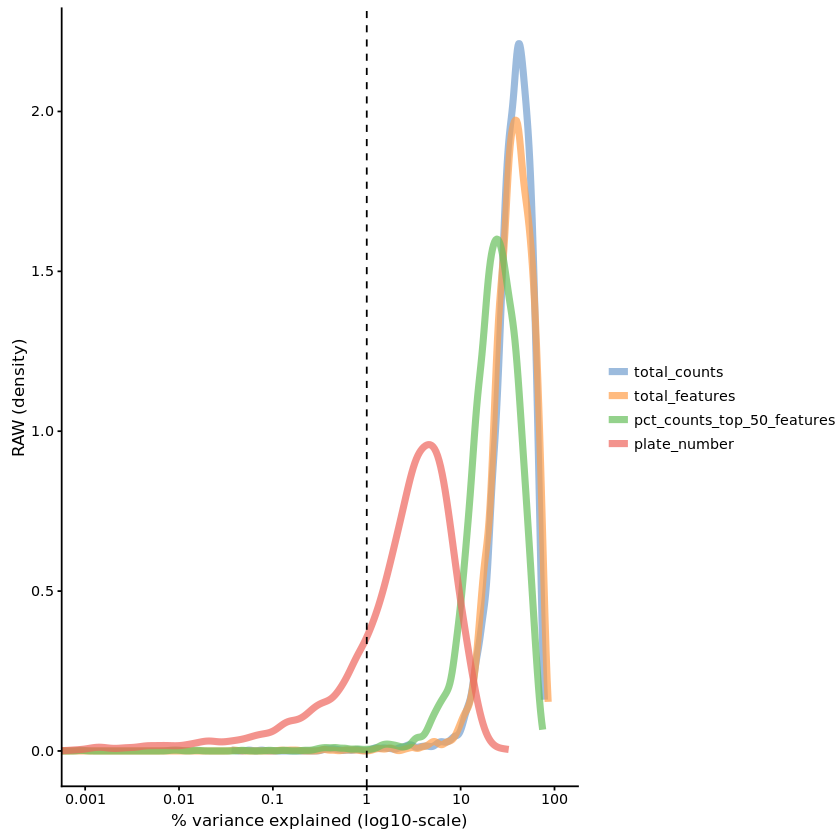

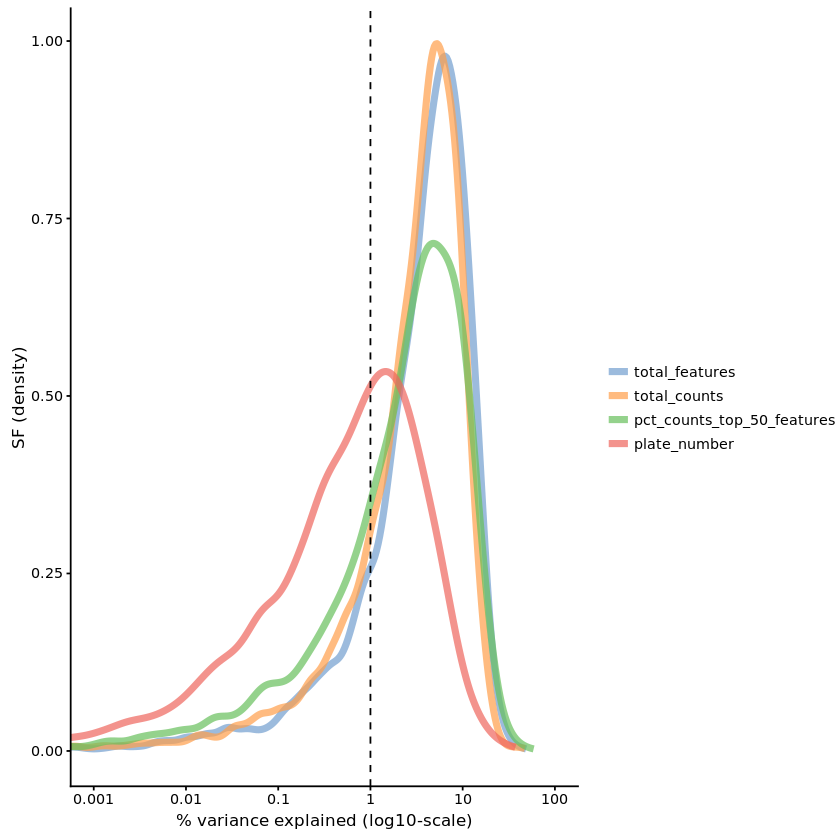

In [5]:
for (mess in list(sce_raw, sce_sf)){
#for (mess in list(sce_raw, sce_cpm, sce_sf, sce_tmm)){
    print(plotQC(mess, type = "expl", exprs_values = "logcounts",
            variables = c("total_features", "total_counts", "pct_counts_top_50_features", "plate_number")
    ) + ylab(paste(mess$namer, " (density)", sep="")))
}

#plotExprsVsTxLength(sce)

By comparing the raw data (top) with the normalised data (bottom) we can see that the plate number each cell was assigned to now explains for a smaller portion of the data at half the strength it used to before.

The same is true for the total number of genes (total_features) and number of counts (total_counts), which have decreased significantly (log50 → log5) in variance explained, and reduced in strength (2+ → 1), most of all offering the same explaning power as each other (which is desired).



In [6]:
saveRDS(sce_sf, "matrix.cellQC.geneQC.normalised.rds")